# Explore Exercises

## Zillow

Create a python script or jupyter notebook named explore_zillow that does the following:

Plot all continuous or numeric/ordered variables against each other in scatterplots, or through a pairplot.

Plot a correlation matrix heatmap.

Plot latitude agains longitude.

Create a useable plot with 4 dimensions, e.g. x, y, color, size.

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

## Changed exercises from Maggie
Zillow Dataset

Create a python script or jupyter notebook named explore_zillow and do the following:

Ask at least 5 questions about the data, keeping in mind that your target variable is logerror.
- e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Answer those questions through a mix of statistical tests and visualizations.

In your exploration, be sure you include the following:
- a plot with at least 3 dimensions, such as x, y, and color.
- at least 3 different types of plots (like box, scatter, bar, ...)
- at least 2 statistical tests.
- document takeaways/conclusions after each question is addressed.

Bonus:      
- Compute the mean(logerror) by zipcode and the overall mean(logerror).   
- Write a loop that will run a t-test between the overall mean and the mean for each zip code.   
- We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [1]:
# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Exploring
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

# Stats
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy import stats
pd.options.display.float_format = '{:20,.2f}'.format

import acquire
import summarize
import prepare
import explore
import wrangle_zillow


(28971, 22) (12417, 22) (10347, 22)
(28971, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28971 entries, 25135 to 65158
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28971 non-null  int64  
 1   propertylandusetypeid         28971 non-null  float64
 2   bathroomcnt                   28971 non-null  float64
 3   bedroomcnt                    28971 non-null  float64
 4   calculatedfinishedsquarefeet  28971 non-null  float64
 5   fips                          28971 non-null  float64
 6   fullbathcnt                   28971 non-null  float64
 7   latitude                      28971 non-null  float64
 8   longitude                     28971 non-null  float64
 9   propertycountylandusecode     28971 non-null  object 
 10  rawcensustractandblock        28971 non-null  float64
 11  regionidcounty                28971 non-null  float64
 12  regionid

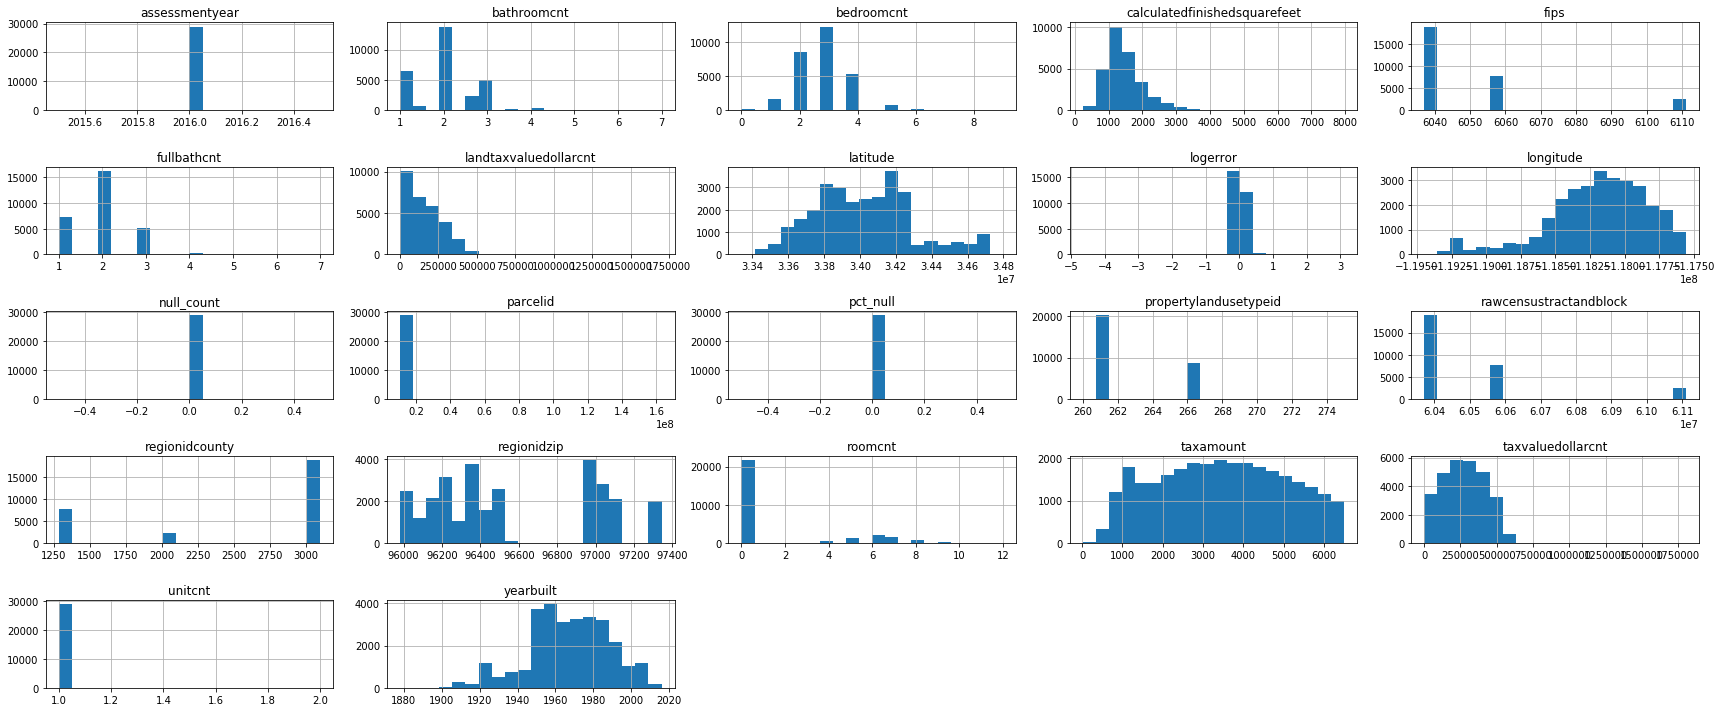

None [[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4296fc650>
  <matplotlib.axes._subplots.AxesSubplot object at 0x7fb412c08cd0>]] None


In [2]:
# get the currently prepared dataset
# NOTE: the dataset IS scaled but NOT split at this point

train, validate, test = wrangle_zillow.wrangle_zillow_cluster()



**Ask at least 5 questions about the data, keeping in mind that your target variable is logerror.**
1. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
2. How are bedrooms and bathrooms correlated, if at all? Could this be binned as a feature?
3. What is the relationship between calculated sqft and logerror?
4. Is there a relationship between taxamount and logerror?
5. Is there a relationship between yearbuilt and calculated sqft? Could this be binned as a feature?

In [3]:
# 1. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
# visualize logerror by county using fips for county category

# add a column that replaces the fips # with the county name
def get_county(county):
    if county == 6037:
        return 'LA'
    elif county == 6059:
        return 'Orange'
    elif county == 6111:
        return 'Ventura'

train['county'] = train.fips.apply(get_county)

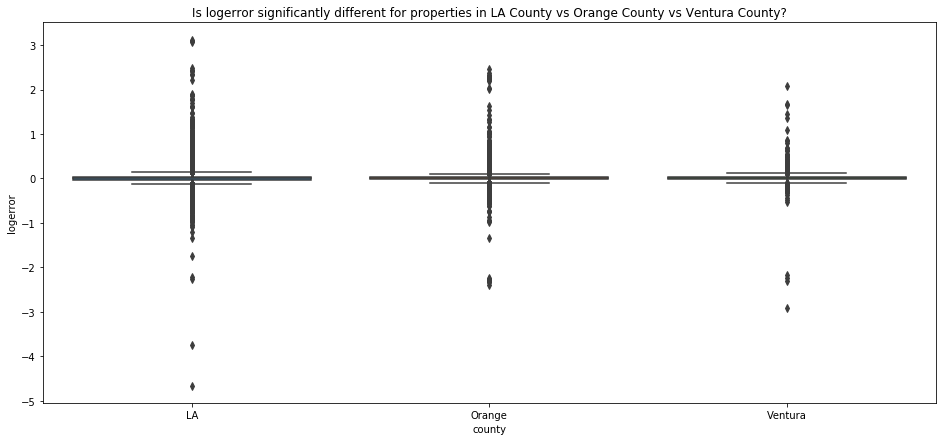

In [4]:
plt.figure(figsize=(16, 7))
sns.boxplot(data = train, x='county', y='logerror')
plt.title('Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?')
plt.show()

*****
Visually logerror does not appear to be different on average by county. However, LA county appears to have the most outliers.
******

**Hypothesis test with Anova because 3 counties**

Ho: The logerror is not significantly different for properties in LA vs Orange vs Ventura counties
Ha: The logerro is significantly different

In [5]:
alpha = .05

LA = train[train.county == "LA"].logerror
Orange = train[train.county == "Orange"].logerror
Ventura = train[train.county == "Ventura"].logerror

In [6]:
stats.levene(LA, Orange, Ventura)
# with a p value < .05 the variances are not similar enough for the ANOVA test
# will use scipy.stats.kruskal

LeveneResult(statistic=21.182833891919376, pvalue=6.414056354407426e-10)

In [7]:
kruskal(LA, Orange, Ventura)
# with the Kruskal test the pvalue is < .05 so we would reject the Ho and conclude
# that there is a significant difference in logerror by county ??

KruskalResult(statistic=10.886712188493263, pvalue=0.004324943967183915)

2. How are bedrooms and bathrooms correlated, if at all? Could this be binned as a feature?

In [8]:
# Create bins for bedrooms and bathrooms to better compare as categorical variables
train['bathroom_bin'] = pd.cut(train.bathroomcnt, bins=[0, 2, 3, 6, 9], labels=['2', '3', '6', '9'])
train['bedroom_bin'] = pd.cut(train.bedroomcnt, bins=[0, 2, 4, 6, 8, 12], labels=['2', '4', '6', '8', '12'])

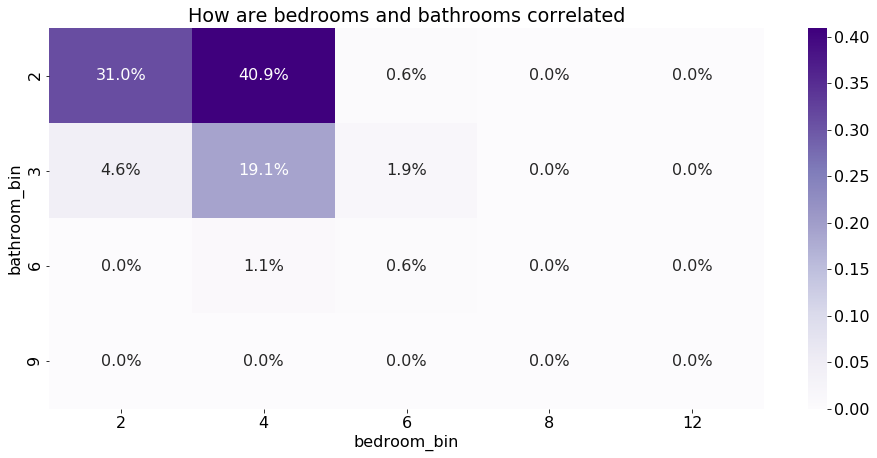

In [9]:
# Heatmap of bined values (Categorical and Categorical)
plt.figure(figsize=(16,7))
plt.rcParams.update({'font.size': 16})
ctab = pd.crosstab(train.bathroom_bin, train.bedroom_bin, normalize=True)
sns.heatmap(ctab, cmap='Purples', annot=True, fmt='.1%')
plt.title('How are bedrooms and bathrooms correlated')
plt.show()

Hypothesis: There is a relationship between # of bedrooms and # of bathrooms 

Ho: Number of Bedrooms and Number of Bathrooms are independent
Ha: Number of Bedrooms and Number of Bathrooms are dependent


In [10]:
# Hypothesis Test

alpha = 0.05
contingency_table = pd.crosstab(train.bathroom_bin, train.bedroom_bin)

chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

if p < alpha:
    print("We reject the null hypothesis")
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis
chi^2 = 7448.8823
p     = 0.0000


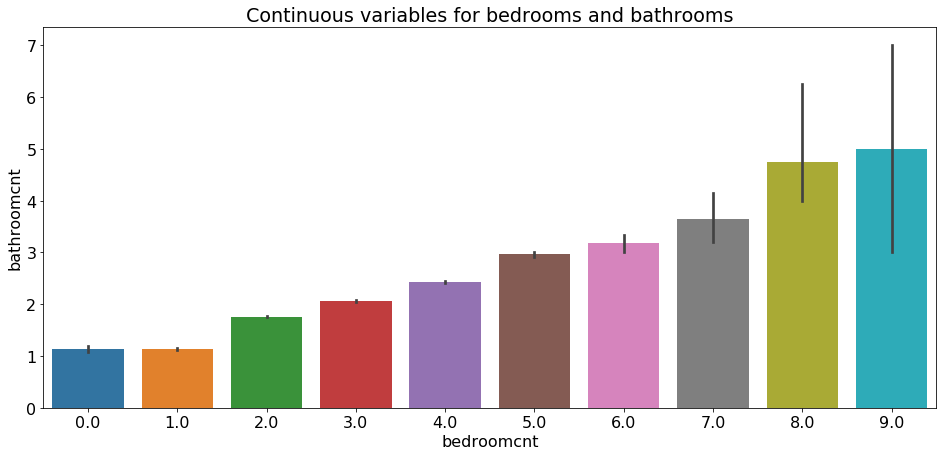

In [11]:
# Does a visualization of continuous values give us more info?
plt.figure(figsize=(16,7))
sns.barplot(data=train, x='bedroomcnt', y='bathroomcnt')
plt.title('Continuous variables for bedrooms and bathrooms')
plt.show()

*****
Not really sure what this tells us. Continuous variables may have linear relationship?    
Maybe 3 groups? 2bed/2bath and under, 3/2 to 6/3, more
******

3. What is the relationship between calculated finished sqft and logerror?

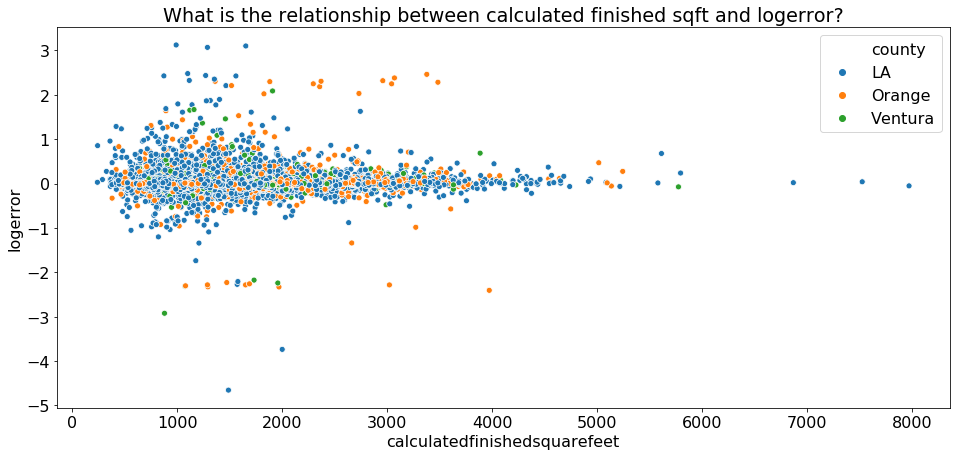

In [12]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=train, x='calculatedfinishedsquarefeet', y='logerror', hue='county')
plt.title('What is the relationship between calculated finished sqft and logerror?')
plt.show()

*****
There appears to be a lot more spread in the logerror with smaller sqft properties. Orange county also appears to have greater spread.
******

4. Is there a relationship between taxamount and logerror?

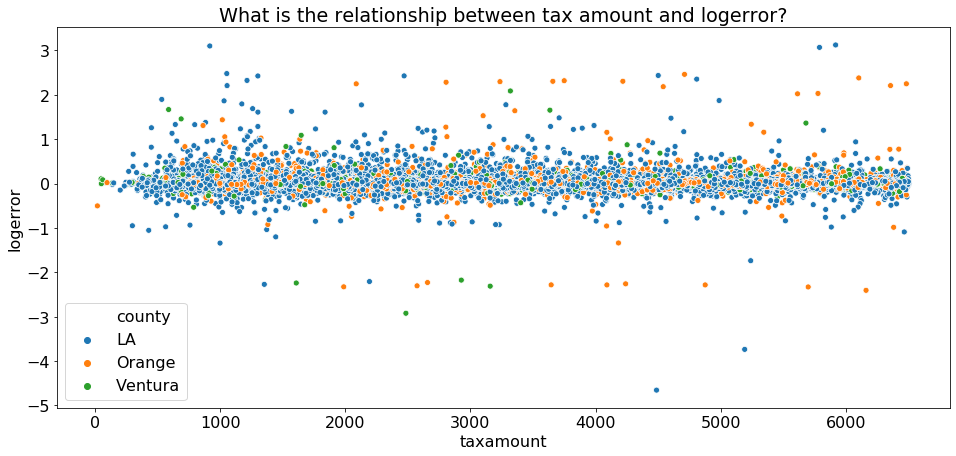

In [13]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=train, x='taxamount', y='logerror', hue='county')
plt.title('What is the relationship between tax amount and logerror?')
plt.show()

*****
Not really sure what this tells us. 
******

5. Is there a relationship between yearbuilt and calculated sqft? Could this be binned as a feature?

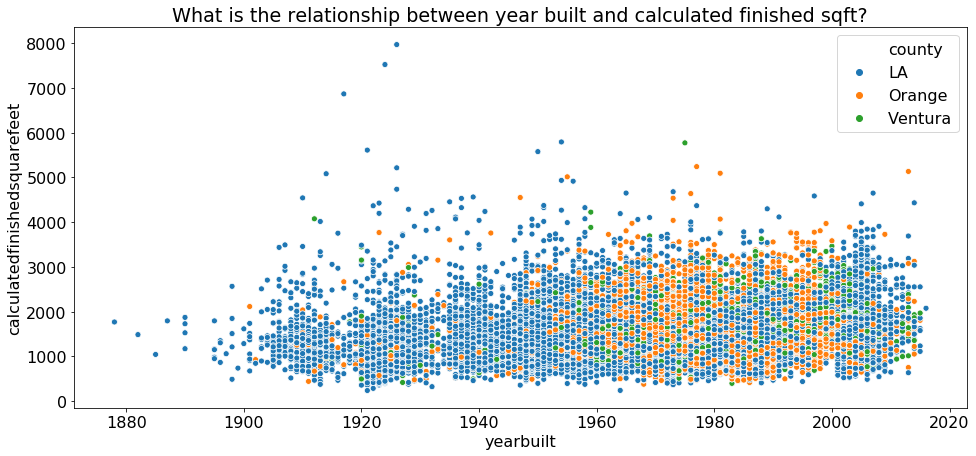

In [14]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=train, x='yearbuilt', y='calculatedfinishedsquarefeet', hue='county')
plt.title('What is the relationship between year built and calculated finished sqft?')
plt.show()

*****
Older homes tend to be smaller, LA and Ventura counties have broad range of age of home, in Orange county homes appear to be primarily built between 1960 and 2000
******

Bonus:      
- Compute the mean(logerror) by zipcode and the overall mean(logerror).   
- Write a loop that will run a t-test between the overall mean and the mean for each zip code.   
- We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [15]:
train.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,propertycountylandusecode,...,yearbuilt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,propertylandusedesc,county,bathroom_bin,bedroom_bin
25135,10838455,261.00,2.00,3.00,"1,538.00","6,037.00",2.00,"34,192,880.00","-118,472,683.00",0100,...,"1,978.00","486,000.00","2,016.00","297,000.00","5,899.50",-0.11,Single Family Residential,LA,2,4
56517,12819457,261.00,2.00,3.00,"1,041.00","6,037.00",2.00,"34,010,093.00","-117,968,564.00",0100,...,"1,956.00","310,760.00","2,016.00","220,587.00","3,737.30",0.01,Single Family Residential,LA,2,4
56070,12643639,266.00,2.00,2.00,961.00,"6,037.00",2.00,"33,757,017.00","-118,298,505.00",010C,...,"1,982.00","299,000.00","2,016.00","184,000.00","3,682.85",-0.01,Condominium,LA,2,2
13963,13931566,261.00,2.00,3.00,"1,221.00","6,059.00",2.00,"33,795,705.00","-117,950,061.00",122,...,"1,955.00","218,908.00","2,016.00","149,028.00","2,819.22",0.17,Single Family Residential,Orange,2,4
4795,12255644,261.00,2.00,3.00,"1,489.00","6,037.00",2.00,"33,888,652.00","-118,268,602.00",0100,...,"1,959.00","49,857.00","2,016.00","14,469.00","1,036.98",-0.04,Single Family Residential,LA,2,4


In [16]:
overall_mean = train.logerror.mean()
overall_mean

0.015608525453179265

In [17]:
train.columns

Index(['parcelid', 'propertylandusetypeid', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'latitude',
       'longitude', 'propertycountylandusecode', 'rawcensustractandblock',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'logerror', 'propertylandusedesc', 'county',
       'bathroom_bin', 'bedroom_bin'],
      dtype='object')

In [18]:
train['regionidzip'] = train.regionidzip.astype(int)
zip_mean = pd.DataFrame(train.groupby('regionidzip')['logerror'].mean())
zip_mean

,logerror
regionidzip,
95982,0.00
95983,0.01
95984,-0.11
95985,-0.06
95986,0.02
...,...
97328,0.02
97329,0.02
97330,0.02


In [19]:
zip_list = train.regionidzip.unique()
zip_list

array([96415, 96489, 96222, 97047, 96105, 97324, 97083, 96190, 97008,
       96954, 96361, 96122, 96411, 96185, 96523, 96123, 96193, 97318,
       96265, 97106, 96951, 96095, 97039, 96522, 96437, 96364, 96186,
       97328, 96963, 96385, 96212, 97052, 96220, 96046, 97026, 96996,
       96505, 96389, 96508, 96341, 96952, 96995, 96355, 96971, 96401,
       97329, 96351, 97118, 96107, 96208, 96173, 96043, 96268, 96234,
       96961, 96217, 97084, 97004, 96116, 96513, 96121, 96946, 96295,
       96403, 96410, 96236, 96327, 97063, 96180, 96218, 96330, 96128,
       96239, 95997, 97065, 96370, 96242, 97319, 97041, 96172, 95982,
       96342, 96024, 96040, 96221, 97016, 96987, 97051, 96377, 96349,
       96352, 96213, 96378, 96160, 96488, 96007, 96464, 96993, 96507,
       97025, 96104, 96087, 96447, 96962, 96414, 96026, 96163, 96086,
       96446, 96215, 96964, 96373, 96106, 96985, 96292, 96383, 96174,
       96469, 96015, 96111, 96003, 96452, 96017, 97081, 97050, 96496,
       96965, 96102,

In [20]:
p_list = []

for i in zip_list:
    t, p = stats.ttest_1samp(train[train.regionidzip == i].logerror, train.logerror.mean())
    p_list.append(p)
    
p_list


[0.10562871038383538,
 0.6833928782395361,
 0.6919122408142586,
 0.969684705030547,
 0.14787978384509284,
 0.19846575427589502,
 0.08260695531224618,
 0.0017484477153017893,
 0.1514148674668329,
 0.7553787085341932,
 0.17949104427749957,
 0.1777412262180375,
 0.2952330648054771,
 0.5150279502900438,
 0.8255145216778321,
 0.5946071466987488,
 0.6021808553686826,
 0.03580189550217508,
 0.9020981099360248,
 0.18004592242936807,
 0.004380451711364051,
 0.3606253982426939,
 0.13555391109925646,
 0.009008740945945453,
 0.0003504739307257321,
 0.9978552222301302,
 0.8977798962083972,
 0.3147587718845277,
 0.1714910270700193,
 0.3850630376389659,
 0.5369365049521135,
 0.3104527827773027,
 0.37789792104985587,
 0.6164208950232386,
 0.2382419079515178,
 0.04766923539951567,
 0.1642798430659311,
 0.8040219276922482,
 0.04721839479992701,
 0.9082496818450885,
 0.34364685235660863,
 0.8544188555401627,
 0.4789905056166265,
 0.1302015876420979,
 0.6498900241968574,
 0.25942996287397485,
 0.513414904

In [21]:
type(zip_list)

numpy.ndarray

In [22]:
type(p_list)

list

In [24]:
statdf = pd.DataFrame(zip_list, columns=['zip'])
statdf['p_value'] = p_list
bonusdf = statdf[statdf.p_value > .05]
bonusdf

,zip,p_value
0,96415,0.11
1,96489,0.68
2,96222,0.69
3,97047,0.97
4,96105,0.15
...,...,...
374,96980,0.62
376,96058,0.77
377,96002,0.18
378,96226,0.36
